# Présentation du projet "Prédiction du tir réussit de NBA"

## Import des modules et sous modules

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import statsmodels.api as sm
import scipy.stats as stats
import statsmodels.api
from scipy.stats import randint

In [ ]:
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.inspection import permutation_importance
from plotly.subplots import make_subplots
from sklearn import preprocessing

In [ ]:
from sklearn.svm import SVR, LinearSVR
from sklearn.tree import DecisionTreeRegressor # regressor = DecisionTreeRegressor(random_state=0)
from sklearn.neural_network import MLPRegressor
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score, confusion_matrix, classification_report, r2_score, mean_squared_error, root_mean_squared_error

# 1.0. Prétraitement des Données
Le prétraitement des données constitue une étape fondamentale dans tout projet d'apprentissage automatique.  

In [ ]:
from google.colab import files
# téléchargez le fichier depuis mon PC vers Google Colab:
upload = files.upload()

Saving nba_data_raw.csv to nba_data_raw.csv


In [ ]:
# Chargement des données brutes
df_raw = pd.read_csv('nba_data_raw.csv')

# Affichage des premières lignes et structure
print(df_raw.head())
print(df_raw.info())

    Game ID  Game Event ID  Player ID    Player Name     Team ID  \
0  21100057            307     201580   JaVale McGee  1610612764   
1  29900683             68       1889   Andre Miller  1610612739   
2  20200012            219       2203  Shane Battier  1610612763   
3  29700558            493        951      Ray Allen  1610612749   
4  20501204            365       2545  Darko Milicic  1610612753   

             Team Name  Period  Minutes Remaining  Seconds Remaining  \
0   Washington Wizards       3                  9                 31   
1  Cleveland Cavaliers       1                  3                 57   
2    Memphis Grizzlies       2                  3                 16   
3      Milwaukee Bucks       4                  0                  7   
4        Orlando Magic       3                  0                 46   

  Action Type  ...         Shot Zone Area  Shot Zone Range Shot Distance  \
0  Layup Shot  ...              Center(C)  Less Than 8 ft.             1   
1   Ju

# Le jeu de données contient des informations sur les tirs effectués lors des matchs NBA, avec notamment:

Informations sur le match (Game ID, Date, équipes)

Caractéristiques du joueur (Player ID, Name)

Détails du tir (position sur le terrain, distance, type)

Variable cible: 'Shot Made Flag' (1 si réussi, 0 sinon)

# 1.1 Nettoyage des Données

In [ ]:
# Vérification et suppression des doublons
duplicates = df_raw.duplicated().sum()
print(f"Nombre de lignes dupliquées: {duplicates}")
df_clean = df_raw.drop_duplicates()

Nombre de lignes dupliquées: 0


In [ ]:
# Gestion des valeurs manquantes
missing_values = df_raw.isnull().sum()
print("Valeurs manquantes par colonne:")
print(missing_values[missing_values > 0])

Valeurs manquantes par colonne:
Series([], dtype: int64)


In [ ]:
# Remplacement des valeurs manquantes pour les colonnes numériques
numeric_cols = ['Shot Distance', 'X Location', 'Y Location']
for col in numeric_cols:
    df_clean[col] = df_clean[col].fillna(df_clean[col].median())

# 1.2 Feature Engineering- Transformation du temps

In [ ]:
# Conversion de la date en format datetime
df_clean['Game Date'] = pd.to_datetime(df_clean['Game Date'], format='%Y%m%d')

# Extraction de caractéristiques temporelles
df_clean['Year'] = df_clean['Game Date'].dt.year
df_clean['Month'] = df_clean['Game Date'].dt.month
df_clean['Day_of_Week'] = df_clean['Game Date'].dt.dayofweek

# Temps restant total en secondes
df_clean['Seconds_Remaining_Total'] = df_clean['Minutes Remaining'] * 60 + df_clean['Seconds Remaining']

# Indicateurs de pression temporelle
df_clean['Clutch_Time'] = ((df_clean['Period'] >= 4) &
                          (df_clean['Minutes Remaining'] <= 2)).astype(int)

# 1.3 Feature Engineering- Transformation des Coordonées Spatiales

In [ ]:
# Distance euclidienne (possiblement redondante avec Shot Distance)
df_clean['Euclidean_Distance'] = np.sqrt(df_clean['X Location']**2 + df_clean['Y Location']**2)

# Angle du tir (en degrés, 0° étant directement devant le panier)
df_clean['Shot_Angle'] = np.arctan2(df_clean['Y Location'], df_clean['X Location']) * 180 / np.pi

# Côté du terrain (gauche/droite)
df_clean['Court_Side'] = np.where(df_clean['X Location'] < 0, 'Left', 'Right')

# Distance au centre du terrain
df_clean['Distance_From_Center'] = abs(df_clean['X Location'])

# 1.4 Feature Engineering - Variable Contextuelles

In [ ]:
# Indicateur si l'équipe joue à domicile
df_clean['Is_Home_Team'] = (df_clean['Team Name'] == df_clean['Home Team']).astype(int)

# Effet domicile/extérieur
conditions = [
    (df_clean['Team Name'] == df_clean['Home Team']),
    (df_clean['Team Name'] == df_clean['Away Team'])
]
choices = ['Home', 'Away']
df_clean['Home_Away'] = np.select(conditions, choices, default='Unknown')

# 1.5 Encodage des Variables Catégorielles

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Identification des variables catégorielles
categorical_cols = ['Action Type', 'Shot Type', 'Shot Zone Basic',
                    'Shot Zone Area', 'Shot Zone Range', 'Court_Side',
                    'Home_Away', 'Season Type']

# Application du One-Hot Encoding
df_encoded = pd.get_dummies(df_clean, columns=categorical_cols, drop_first=True)

# Alternative avec scikit-learn pour plus de contrôle
'''
encoder = OneHotEncoder(sparse=False, drop='first')
encoded_features = encoder.fit_transform(df_clean[categorical_cols])
encoded_df = pd.DataFrame(encoded_features,
                         columns=encoder.get_feature_names_out(categorical_cols))
df_processed = pd.concat([df_clean.drop(categorical_cols, axis=1), encoded_df], axis=1)
'''

"\nencoder = OneHotEncoder(sparse=False, drop='first')\nencoded_features = encoder.fit_transform(df_clean[categorical_cols])\nencoded_df = pd.DataFrame(encoded_features,\n                         columns=encoder.get_feature_names_out(categorical_cols))\ndf_processed = pd.concat([df_clean.drop(categorical_cols, axis=1), encoded_df], axis=1)\n"

# 1.6 Normalisation/Standalisation des Variables Numériques

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Colonnes à standardiser
numeric_features = ['Shot Distance', 'X Location', 'Y Location',
                   'Euclidean_Distance', 'Shot_Angle', 'Distance_From_Center',
                   'Seconds_Remaining_Total']

# Standardisation (moyenne=0, écart-type=1)
scaler = StandardScaler()
df_encoded[numeric_features] = scaler.fit_transform(df_encoded[numeric_features])

# Alternative: normalisation MinMax (valeurs entre 0 et 1)
'''
min_max_scaler = MinMaxScaler()
df_encoded[numeric_features] = min_max_scaler.fit_transform(df_encoded[numeric_features])
'''


'\nmin_max_scaler = MinMaxScaler()\ndf_encoded[numeric_features] = min_max_scaler.fit_transform(df_encoded[numeric_features])\n'

# 1.7 Sélection de Caractéristiques

In [ ]:
## Identifier les colonnes non numériques
non_numeric_columns = df_encoded.select_dtypes(exclude=['number']).columns
print("Colonnes non numériques qui causent l'erreur:", list(non_numeric_columns))

# Filtrer uniquement les colonnes numériques pour le calcul des corrélations
df_numeric = df_encoded.select_dtypes(include=['number'])

# Vérifier que la cible est dans les colonnes numériques
target = 'Shot Made Flag'
if target in df_numeric.columns:
    # Calculer et afficher les corrélations
    correlations = df_numeric.corr()[target].sort_values(ascending=False)
    print("Top 10 des caractéristiques les plus corrélées:")
    print(correlations.head(11))  # +1 car la cible elle-même sera aussi incluse
else:
    print(f"Attention: La colonne cible '{target}' n'est pas présente dans le dataframe numérique")

# Suppression de toutes les colonnes non pertinentes (y compris les colonnes textuelles)
columns_to_drop = ['Game ID', 'Game Event ID', 'Player Name',
                  'Team ID', 'Team Name', 'Home Team', 'Away Team', 'Game Date']

# S'assurer que ces colonnes existent encore dans le DataFrame
# et ajouter toutes les colonnes non numériques identifiées
columns_to_drop = [col for col in columns_to_drop if col in df_encoded.columns]
columns_to_drop = list(set(columns_to_drop + list(non_numeric_columns)))

# Créer le DataFrame final sans les colonnes à supprimer
df_final = df_encoded.drop(columns=columns_to_drop, errors='ignore')

# Vérification finale - s'assurer qu'il ne reste plus de colonnes non numériques
remaining_non_numeric = df_final.select_dtypes(exclude=['number']).columns
if len(remaining_non_numeric) > 0:
    print("Attention: Il reste encore des colonnes non numériques:", list(remaining_non_numeric))
    # Si nécessaire, encoder automatiquement ces colonnes restantes
    df_final = pd.get_dummies(df_final, drop_first=True)

# Réorganiser pour avoir la cible à la fin
cols = [col for col in df_final.columns if col != target] + [target]
df_final = df_final[cols]

print(f"Dimensions du dataset final après sélection des caractéristiques: {df_final.shape}")


Colonnes non numériques qui causent l'erreur: ['Player Name', 'Team Name', 'Game Date', 'Home Team', 'Away Team', 'Action Type_Alley Oop Layup shot', 'Action Type_Cutting Dunk Shot', 'Action Type_Cutting Layup Shot', 'Action Type_Driving Dunk Shot', 'Action Type_Driving Finger Roll Layup Shot', 'Action Type_Driving Finger Roll Shot', 'Action Type_Driving Floating Jump Shot', 'Action Type_Driving Hook Shot', 'Action Type_Driving Jump shot', 'Action Type_Driving Layup Shot', 'Action Type_Driving Reverse Layup Shot', 'Action Type_Dunk Shot', 'Action Type_Fadeaway Jump Shot', 'Action Type_Finger Roll Layup Shot', 'Action Type_Floating Jump shot', 'Action Type_Follow Up Dunk Shot', 'Action Type_Hook Shot', 'Action Type_Jump Bank Shot', 'Action Type_Jump Hook Shot', 'Action Type_Jump Shot', 'Action Type_Layup Shot', 'Action Type_Pullup Bank shot', 'Action Type_Pullup Jump shot', 'Action Type_Putback Dunk Shot', 'Action Type_Putback Layup Shot', 'Action Type_Putback Slam Dunk Shot', 'Action T

# 1.8 Finalisation et Enrégistrement du dataset prétraité

In [ ]:
# Réorganisation des colonnes (variable cible à la fin)
cols = [col for col in df_final.columns if col != target] + [target]
df_final = df_final[cols]

# Vérification finale
print(f"Dimensions du dataset final: {df_final.shape}")

# Enregistrement du fichier prétraité
df_final.to_csv('nba_data_processed.csv', index=False)

Dimensions du dataset final: (1000, 17)


# 1.9 Intégration des étapes en Pipeline Complet

Dimensions du dataset brut: (1000, 22)
Premières lignes:
    Game ID  Game Event ID  Player ID    Player Name     Team ID  \
0  21100057            307     201580   JaVale McGee  1610612764   
1  29900683             68       1889   Andre Miller  1610612739   
2  20200012            219       2203  Shane Battier  1610612763   
3  29700558            493        951      Ray Allen  1610612749   
4  20501204            365       2545  Darko Milicic  1610612753   

             Team Name  Period  Minutes Remaining  Seconds Remaining  \
0   Washington Wizards       3                  9                 31   
1  Cleveland Cavaliers       1                  3                 57   
2    Memphis Grizzlies       2                  3                 16   
3      Milwaukee Bucks       4                  0                  7   
4        Orlando Magic       3                  0                 46   

  Action Type  ...         Shot Zone Area  Shot Zone Range Shot Distance  \
0  Layup Shot  ...       

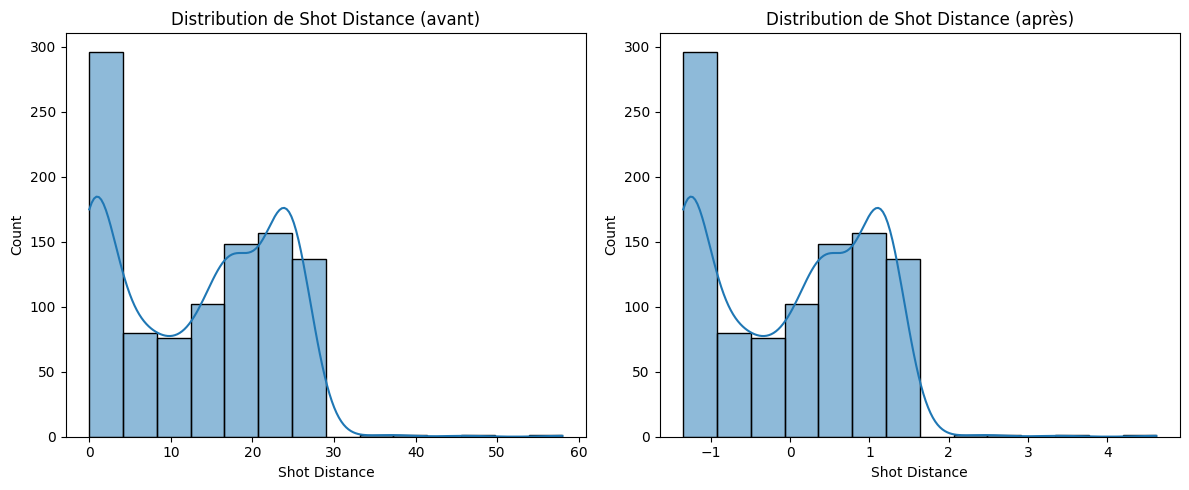

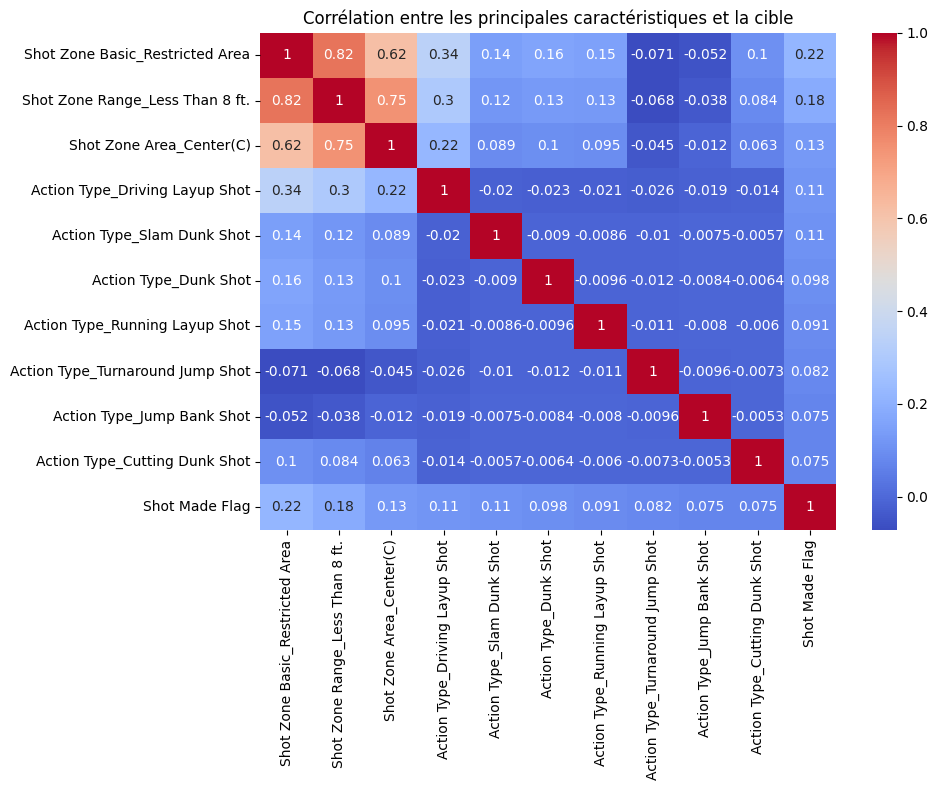

Prétraitement terminé et fichier sauvegardé avec succès!


In [ ]:
# Pour faciliter l'intégration dans Google Colab, voici le script complet combinant toutes les étapes:

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# 1. Chargement et exploration initiale
df_raw = pd.read_csv('nba_data_raw.csv')
print("Dimensions du dataset brut:", df_raw.shape)
print("Premières lignes:")
print(df_raw.head())

# 2. Nettoyage des données
df_clean = df_raw.drop_duplicates()
numeric_cols = ['Shot Distance', 'X Location', 'Y Location']
for col in numeric_cols:
    df_clean[col] = df_clean[col].fillna(df_clean[col].median())

# 3. Feature Engineering - Temps
df_clean['Game Date'] = pd.to_datetime(df_clean['Game Date'], format='%Y%m%d')
df_clean['Year'] = df_clean['Game Date'].dt.year
df_clean['Month'] = df_clean['Game Date'].dt.month
df_clean['Day_of_Week'] = df_clean['Game Date'].dt.dayofweek
df_clean['Seconds_Remaining_Total'] = df_clean['Minutes Remaining'] * 60 + df_clean['Seconds Remaining']
df_clean['Clutch_Time'] = ((df_clean['Period'] >= 4) & (df_clean['Minutes Remaining'] <= 2)).astype(int)

# 4. Feature Engineering - Coordonnées spatiales
df_clean['Euclidean_Distance'] = np.sqrt(df_clean['X Location']**2 + df_clean['Y Location']**2)
df_clean['Shot_Angle'] = np.arctan2(df_clean['Y Location'], df_clean['X Location']) * 180 / np.pi
df_clean['Court_Side'] = np.where(df_clean['X Location'] < 0, 'Left', 'Right')
df_clean['Distance_From_Center'] = abs(df_clean['X Location'])

# 5. Feature Engineering - Variables contextuelles
df_clean['Is_Home_Team'] = (df_clean['Team Name'] == df_clean['Home Team']).astype(int)
conditions = [(df_clean['Team Name'] == df_clean['Home Team']), (df_clean['Team Name'] == df_clean['Away Team'])]
choices = ['Home', 'Away']
df_clean['Home_Away'] = np.select(conditions, choices, default='Unknown')

# 6. Encodage des variables catégorielles
categorical_cols = ['Action Type', 'Shot Type', 'Shot Zone Basic', 'Shot Zone Area',
                   'Shot Zone Range', 'Court_Side', 'Home_Away', 'Season Type']
df_encoded = pd.get_dummies(df_clean, columns=categorical_cols, drop_first=True)

# 7. Normalisation/Standardisation
numeric_features = ['Shot Distance', 'X Location', 'Y Location', 'Euclidean_Distance',
                   'Shot_Angle', 'Distance_From_Center', 'Seconds_Remaining_Total']
scaler = StandardScaler()
df_encoded[numeric_features] = scaler.fit_transform(df_encoded[numeric_features])

# 8. Sélection de caractéristiques
target = 'Shot Made Flag'
columns_to_drop = ['Game ID', 'Game Event ID',  'Player Name',
                  'Team ID', 'Team Name', 'Home Team', 'Away Team', 'Game Date']
df_final = df_encoded.drop(columns=columns_to_drop)

# 9. Finalisation
cols = [col for col in df_final.columns if col != target] + [target]
df_final = df_final[cols]
print(f"Dimensions du dataset final: {df_final.shape}")

# Visualisation des distributions avant/après prétraitement
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df_raw['Shot Distance'], kde=True)
plt.title('Distribution de Shot Distance (avant)')
plt.subplot(1, 2, 2)
sns.histplot(df_final['Shot Distance'], kde=True)
plt.title('Distribution de Shot Distance (après)')
plt.tight_layout()
plt.show()

# Matrice de corrélation avec la cible
plt.figure(figsize=(10, 8))
correlations = df_final.corr()[target].sort_values(ascending=False)
top_features = correlations.drop(target).head(10).index
sns.heatmap(df_final[list(top_features) + [target]].corr(), annot=True, cmap='coolwarm')
plt.title('Corrélation entre les principales caractéristiques et la cible')
plt.tight_layout()
plt.show()

# Enregistrement du fichier prétraité
df_final.to_csv('nba_data_processed.csv', index=False)
print("Prétraitement terminé et fichier sauvegardé avec succès!")